<a href="https://colab.research.google.com/github/shakshiyadav27/ds_shakshi/blob/main/notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:

CANDIDATE_NAME = "Shakshi"
ROOT = f"ds_{CANDIDATE_NAME}"
CSV_DIR = f"{ROOT}/csv_files"
OUT_DIR = f"{ROOT}/outputs"

import os
os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# Print structure
print("Root:", ROOT)
print("CSV_DIR:", CSV_DIR)
print("OUT_DIR:", OUT_DIR)


Root: ds_Shakshi
CSV_DIR: ds_Shakshi/csv_files
OUT_DIR: ds_Shakshi/outputs


In [100]:

!pip install --quiet gdown


In [101]:


import gdown

# Trader data
trader_id = "1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"
trader_url = f"https://drive.google.com/uc?id={trader_id}"
trader_out = f"{CSV_DIR}/historical_trades.csv"
print("Downloading trader data...")
gdown.download(trader_url, trader_out, quiet=False)

# Sentiment data
sentiment_id = "1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"
sentiment_url = f"https://drive.google.com/uc?id={sentiment_id}"
sentiment_out = f"{CSV_DIR}/fear_greed.csv"
print("Downloading sentiment data...")
gdown.download(sentiment_url, sentiment_out, quiet=False)

print("Files saved to:", CSV_DIR)


Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/ds_Shakshi/csv_files/historical_trades.csv
100%|██████████| 47.5M/47.5M [00:00<00:00, 207MB/s]


Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/ds_Shakshi/csv_files/fear_greed.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 14.4MB/s]

Files saved to: ds_Shakshi/csv_files


In [102]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

# plotting defaults
plt.rcParams['figure.figsize'] = (10,5)


In [103]:
# load datasets
trades_path = f"{CSV_DIR}/historical_trades.csv"
sent_path = f"{CSV_DIR}/fear_greed.csv"

def smart_read_csv(path):
    for sep in [',',';','\t']:
        try:
            df = pd.read_csv(path, sep=sep, low_memory=False)
            if df.shape[1] > 1:
                return df
        except Exception as e:
            pass
    raise ValueError("Failed to read CSV: " + path)

trades = smart_read_csv(trades_path)
sent = smart_read_csv(sent_path)

print("Trades shape:", trades.shape)
print("Sentiment shape:", sent.shape)
trades.head()


Trades shape: (211224, 16)
Sentiment shape: (2644, 4)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [104]:

# lowercase columns and strip spaces
trades.columns = [c.strip().lower().replace(' ','_') for c in trades.columns]
sent.columns = [c.strip().lower().replace(' ','_') for c in sent.columns]

# Show columns
print("Trade columns:", trades.columns.tolist())
print("Sentiment columns:", sent.columns.tolist())


Trade columns: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']
Sentiment columns: ['timestamp', 'value', 'classification', 'date']


In [105]:


# Make educated guesses for column names:
time_cols = [c for c in trades.columns if 'time' in c or 'timestamp' in c or 'date' in c]
print("Possible time columns:", time_cols)

# Convert first candidate time column to datetime
if time_cols:
    trades['trade_time'] = pd.to_datetime(trades[time_cols[0]], errors='coerce', utc=True)
else:
    # If no time col, try 'created_at' or similar
    trades['trade_time'] = pd.NaT

# Numeric conversions
for col in ['execution_price','price','size_usd','closedpnl','closed_pnl']:
    if col in trades.columns:
        trades[col] = pd.to_numeric(trades[col], errors='coerce')

# normalize PnL column name
if 'closedpnl' in trades.columns and 'closed_pnl' not in trades.columns:
    trades['closed_pnl'] = trades['closedpnl']

# handle side column
if 'side' in trades.columns:
    trades['side'] = trades['side'].astype(str).str.lower()

trades[['trade_time','execution_price','size_usd','closed_pnl']].head()


Possible time columns: ['timestamp_ist', 'timestamp']


,trade_time,execution_price,size_usd,closed_pnl
0,2024-02-12 22:50:00+00:00,7.9769,7872.16,0.0
1,2024-02-12 22:50:00+00:00,7.9800,127.68,0.0
2,2024-02-12 22:50:00+00:00,7.9855,1150.63,0.0
3,2024-02-12 22:50:00+00:00,7.9874,1142.04,0.0
4,2024-02-12 22:50:00+00:00,7.9894,69.75,0.0


In [106]:
# --- Clean and balance sentiment labels ---
df_clean = merged.copy()

# Combine related sentiments
df_clean['sentiment_clean'] = df_clean['classification'].replace({
    'Extreme Greed': 'Greed',
    'Extreme Fear': 'Fear'
})

# Filter only Fear & Greed rows
df_model = df_clean[df_clean['sentiment_clean'].isin(['Fear','Greed'])].copy()
df_model['label'] = (df_model['sentiment_clean'] == 'Greed').astype(int)

print(df_model['sentiment_clean'].value_counts())


sentiment_clean
Greed    99
Fear     43
Name: count, dtype: int64


In [107]:

# notional = execution_price * size; if either missing -> NaN
trades['notional'] = trades['execution_price'] * trades['size_usd']

# signed_size based on side; if side missing -> 0 (neutral)

sign_map = {'buy':1,'long':1,'b':1,'sell':-1,'short':-1,'s':-1}
trades['signed_size'] = trades['size_usd'] * trades['side'].map(sign_map).fillna(0)

# is_win only if closed_pnl exists
trades['is_win'] = np.where(trades['closed_pnl'].notna(), (trades['closed_pnl']>0).astype(int), np.nan)
# quick check
display(trades[['trade_time','execution_price','size_usd','notional','signed_size','closed_pnl','is_win']].head())



,trade_time,execution_price,size_usd,notional,signed_size,closed_pnl,is_win
0,2024-02-12 22:50:00+00:00,7.9769,7872.16,62795.433104,7872.16,0.0,0.0
1,2024-02-12 22:50:00+00:00,7.9800,127.68,1018.886400,127.68,0.0,0.0
2,2024-02-12 22:50:00+00:00,7.9855,1150.63,9188.355865,1150.63,0.0,0.0
3,2024-02-12 22:50:00+00:00,7.9874,1142.04,9121.930296,1142.04,0.0,0.0
4,2024-02-12 22:50:00+00:00,7.9894,69.75,557.260650,69.75,0.0,0.0


In [108]:
# If trade_time is NaT for all rows, fallback to grouping by index
if trades['trade_time'].notna().any():
    trades['trade_date'] = pd.to_datetime(trades['trade_time']).dt.tz_convert(None).dt.date
else:
    # fallback: use a placeholder date for all so we still aggregate overall stats
    trades['trade_date'] = pd.to_datetime('1970-01-01').date()
    print("trade_time missing for all rows -> Aggregating all trades under single date 1970-01-01")

# Aggregation functions - use .sum/.mean which handle NaNs
agg = trades.groupby('trade_date').agg(
    total_trades=('account','count'),
    total_volume=('notional','sum'),
    avg_closed_pnl=('closed_pnl','mean'),
    median_closed_pnl=('closed_pnl','median'),
    net_pnl=('closed_pnl','sum'),
    win_rate=('is_win','mean'),
    unique_accounts=('account','nunique')
).reset_index()

# top-account concentration safe function
def topk_share_safe(df, k=10):
    if df['notional'].notna().sum() == 0:
        return np.nan
    s = df.groupby('account')['notional'].sum().sort_values(ascending=False)
    top = s.head(k).sum()
    total = s.sum()
    return (top/total) if total>0 else np.nan

top10_shares = []
for d, g in trades.groupby('trade_date'):
    top10_shares.append({'trade_date': d, 'top10_volume_share': topk_share_safe(g, 10)})
top10_df = pd.DataFrame(top10_shares)
agg = agg.merge(top10_df, on='trade_date', how='left')

agg['trade_date'] = pd.to_datetime(agg['trade_date'])
agg = agg.sort_values('trade_date')
agg.head(10)


,trade_date,total_trades,total_volume,avg_closed_pnl,median_closed_pnl,net_pnl,win_rate,unique_accounts,top10_volume_share
0,2023-01-05,3,9.053943e+05,0.000000,0.00000,0.000000,0.000000,1,1.0
1,2023-05-12,9,1.102369e+09,0.000000,0.00000,0.000000,0.000000,1,1.0
2,2024-01-01,18,4.522448e+09,-7.196192,0.00000,-129.531460,0.055556,1,1.0
3,2024-01-02,6,1.842958e+02,0.000000,0.00000,0.000000,0.000000,1,1.0
4,2024-01-03,137,9.614479e+05,60.176945,27.04384,8244.241409,0.934307,1,1.0
5,2024-01-04,77,4.752281e+08,32.570953,0.54675,2507.963406,0.545455,2,1.0
6,2024-01-05,14,2.539456e+08,0.000000,0.00000,0.000000,0.000000,1,1.0
7,2024-01-06,25,1.549302e+04,3.660417,0.00000,91.510419,0.360000,1,1.0
8,2024-01-07,64,1.140823e+09,79.153739,0.00000,5065.839308,0.406250,2,1.0
9,2024-01-08,57,2.248752e+09,2.931228,0.00000,167.080017,0.070175,4,1.0


In [109]:
# Merge with sentiment
agg['date'] = agg['trade_date'].dt.date
merged = agg.merge(sent.rename(columns={'date_parsed':'date'}), on='date', how='left')
merged['classification'] = merged['classification'].fillna('Unknown')
merged.head()
# Save merged for inspection
merged.to_csv(f"{CSV_DIR}/daily_trader_sentiment_merged_safe.csv", index=False)
print("Saved merged csv at:", f"{CSV_DIR}/daily_trader_sentiment_merged_safe.csv")


Saved merged csv at: ds_Shakshi/csv_files/daily_trader_sentiment_merged_safe.csv


In [110]:
#sentiment data cleaning
print("Sentiment dataset columns:", sent.columns.tolist())

# possible date and classification columns
date_col = [c for c in sent.columns if 'date' in c.lower()]
class_col = [c for c in sent.columns if 'class' in c.lower() or 'fear' in c.lower() or 'greed' in c.lower()]

# Parse date column
if date_col:
    sent['date_parsed'] = pd.to_datetime(sent[date_col[0]], errors='coerce').dt.date
else:
    sent['date_parsed'] = pd.to_datetime(sent.iloc[:,0], errors='coerce').dt.date

# Extract classification
if class_col:
    sent['classification'] = sent[class_col[0]]
else:
    sent['classification'] = sent.iloc[:,1]

# Normalize text
sent['classification'] = sent['classification'].astype(str).str.strip().str.title()
sent = sent[['date_parsed','classification']].dropna()
sent.head(10)


Sentiment dataset columns: ['timestamp', 'value', 'classification', 'date']


,date_parsed,classification
0,2018-02-01,Fear
1,2018-02-02,Extreme Fear
2,2018-02-03,Fear
3,2018-02-04,Extreme Fear
4,2018-02-05,Extreme Fear
5,2018-02-06,Extreme Fear
6,2018-02-07,Fear
7,2018-02-08,Fear
8,2018-02-09,Fear
9,2018-02-10,Neutral


In [111]:
# --- Cell 11: merge trader data + sentiment ---
agg['date'] = agg['trade_date'].dt.date
merged = agg.merge(sent.rename(columns={'date_parsed':'date'}), on='date', how='left')
merged['classification'] = merged['classification'].fillna('Unknown')

print("Merged dataset shape:", merged.shape)
display(merged.head(10))

merged.to_csv(f"{CSV_DIR}/daily_trader_sentiment_merged.csv", index=False)


Merged dataset shape: (188, 11)


,trade_date,total_trades,total_volume,avg_closed_pnl,median_closed_pnl,net_pnl,win_rate,unique_accounts,top10_volume_share,date,classification
0,2023-01-05,3,9.053943e+05,0.000000,0.00000,0.000000,0.000000,1,1.0,2023-01-05,Fear
1,2023-05-12,9,1.102369e+09,0.000000,0.00000,0.000000,0.000000,1,1.0,2023-05-12,Neutral
2,2024-01-01,18,4.522448e+09,-7.196192,0.00000,-129.531460,0.055556,1,1.0,2024-01-01,Greed
3,2024-01-02,6,1.842958e+02,0.000000,0.00000,0.000000,0.000000,1,1.0,2024-01-02,Greed
4,2024-01-03,137,9.614479e+05,60.176945,27.04384,8244.241409,0.934307,1,1.0,2024-01-03,Greed
5,2024-01-04,77,4.752281e+08,32.570953,0.54675,2507.963406,0.545455,2,1.0,2024-01-04,Greed
6,2024-01-05,14,2.539456e+08,0.000000,0.00000,0.000000,0.000000,1,1.0,2024-01-05,Greed
7,2024-01-06,25,1.549302e+04,3.660417,0.00000,91.510419,0.360000,1,1.0,2024-01-06,Greed
8,2024-01-07,64,1.140823e+09,79.153739,0.00000,5065.839308,0.406250,2,1.0,2024-01-07,Greed
9,2024-01-08,57,2.248752e+09,2.931228,0.00000,167.080017,0.070175,4,1.0,2024-01-08,Greed


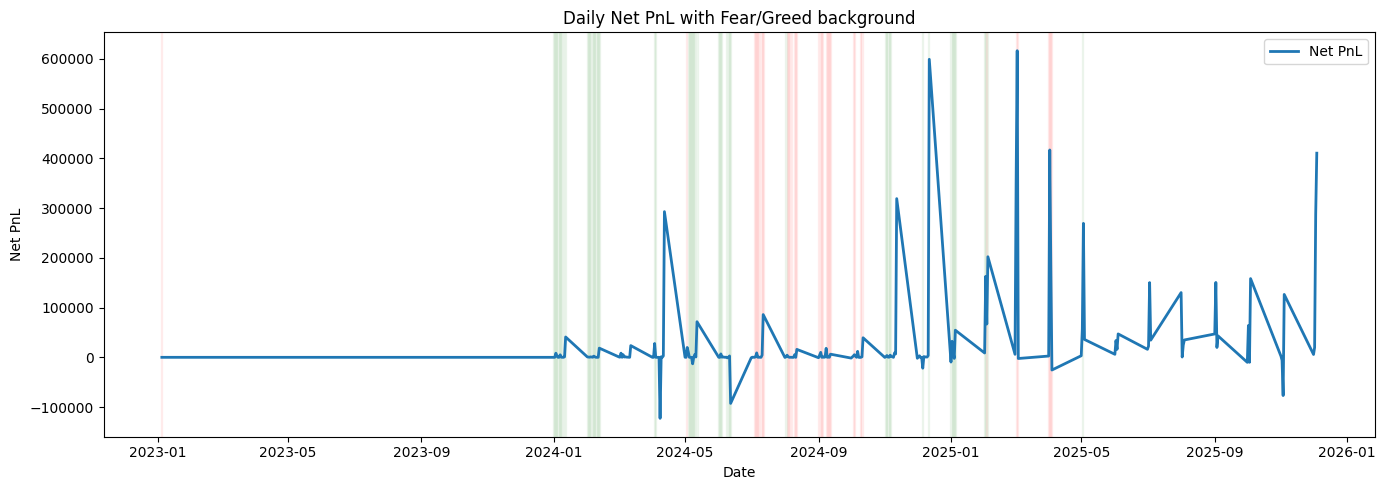

In [112]:
import matplotlib.dates as mdates

plt.figure(figsize=(14,5))
plt.plot(merged['trade_date'], merged['net_pnl'], label='Net PnL', lw=2)

for i, row in merged.iterrows():
    if row['classification'] == 'Fear':
        plt.axvspan(row['trade_date'] - pd.Timedelta(days=0.5), row['trade_date'] + pd.Timedelta(days=0.5), color='red', alpha=0.05)
    elif row['classification'] == 'Greed':
        plt.axvspan(row['trade_date'] - pd.Timedelta(days=0.5), row['trade_date'] + pd.Timedelta(days=0.5), color='green', alpha=0.05)

plt.title("Daily Net PnL with Fear/Greed background")
plt.xlabel("Date")
plt.ylabel("Net PnL")
plt.legend()
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/netpnl_timeseries.png")
plt.show()


/tmp/ipython-input-513197040.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='classification', y=m, data=df_plot, palette='Set2')


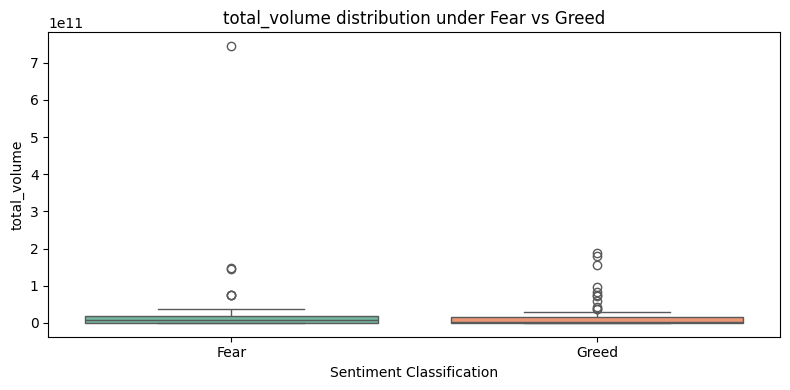

/tmp/ipython-input-513197040.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='classification', y=m, data=df_plot, palette='Set2')


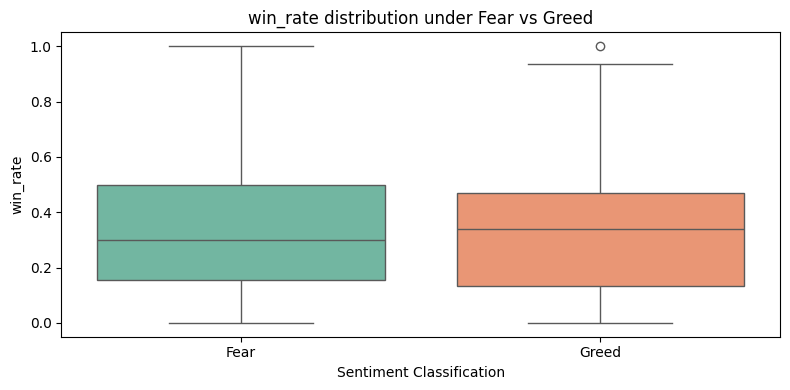

/tmp/ipython-input-513197040.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='classification', y=m, data=df_plot, palette='Set2')


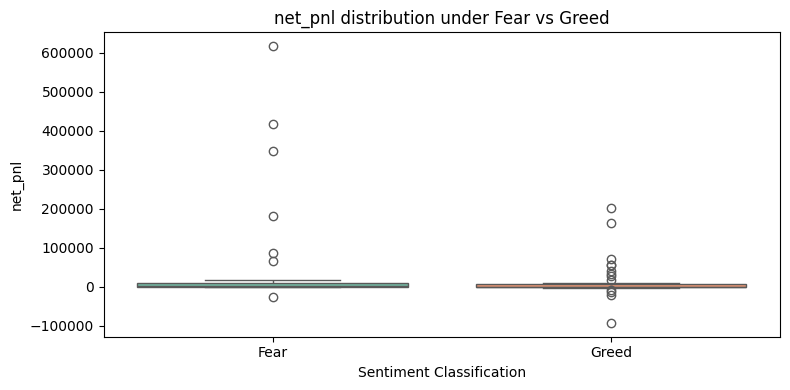

/tmp/ipython-input-513197040.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='classification', y=m, data=df_plot, palette='Set2')


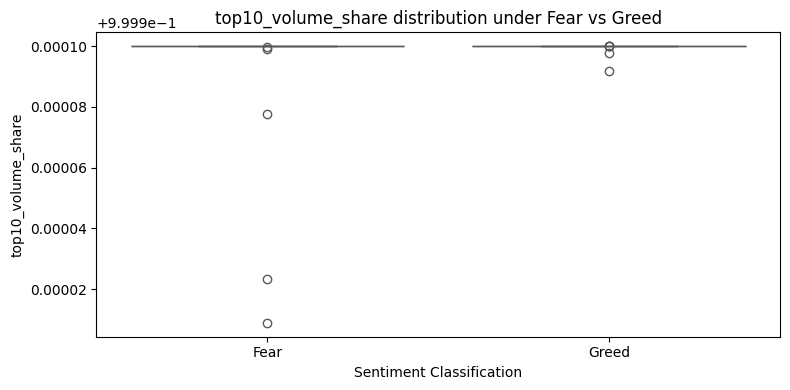

In [113]:
# --- FIXED BOX PLOT CODE (safe for empty/NaN columns) ---
metrics = ['total_volume','win_rate','net_pnl','top10_volume_share']

for m in metrics:
    df_plot = merged.loc[merged['classification'].isin(['Fear','Greed']), ['classification', m]].dropna()

    if df_plot.empty or df_plot[m].nunique() <= 1:
        print(f"⚠️ Skipping {m}: insufficient or missing data for boxplot.")
        continue  # skip this metric

    plt.figure(figsize=(8,4))
    sns.boxplot(x='classification', y=m, data=df_plot, palette='Set2')
    plt.title(f"{m} distribution under Fear vs Greed")
    plt.xlabel("Sentiment Classification")
    plt.ylabel(m)
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/box_{m}.png")
    plt.show()


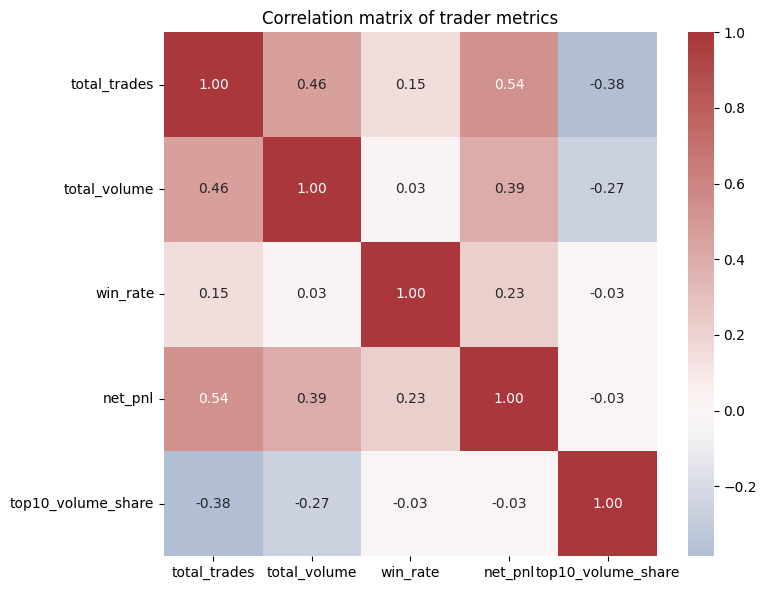

In [114]:
corr_cols = ['total_trades','total_volume','win_rate','net_pnl','top10_volume_share']
corr = merged[corr_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title("Correlation matrix of trader metrics")
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/corr_matrix.png")
plt.show()


In [115]:
from scipy import stats

results = []
for m in metrics:
    data_fear = merged.loc[merged['classification']=='Fear', m].dropna()
    data_greed = merged.loc[merged['classification']=='Greed', m].dropna()
    if len(data_fear) >= 3 and len(data_greed) >= 3:
        tstat, pval = stats.ttest_ind(data_fear, data_greed, equal_var=False, nan_policy='omit')
        mw_stat, mw_p = stats.mannwhitneyu(data_fear, data_greed, alternative='two-sided')
        results.append({
            'Metric': m,
            'Mean_Fear': data_fear.mean(),
            'Mean_Greed': data_greed.mean(),
            'T-test_p': round(pval,4),
            'MannWhitney_p': round(mw_p,4)
        })

results_df = pd.DataFrame(results)
display(results_df)

results_df.to_csv(f"{CSV_DIR}/statistical_results.csv", index=False)


,Metric,Mean_Fear,Mean_Greed,T-test_p,MannWhitney_p
0,total_volume,4.101849e+10,2.117311e+10,0.3559,0.3944
1,win_rate,3.480707e-01,3.624148e-01,0.8145,0.7203
2,net_pnl,4.808718e+04,1.088630e+04,0.1059,0.4788
3,top10_volume_share,9.999948e-01,9.999998e-01,0.1292,0.4179


In [116]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

X = df_model[['total_trades','total_volume','win_rate','net_pnl','top10_volume_share']].fillna(0)
y = df_model['label']

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.25, random_state=42, stratify=y)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", round(roc_auc_score(y_test, y_prob),3))


              precision    recall  f1-score   support

           0       0.33      0.09      0.14        11
           1       0.70      0.92      0.79        25

    accuracy                           0.67        36
   macro avg       0.52      0.51      0.47        36
weighted avg       0.59      0.67      0.59        36

ROC-AUC Score: 0.491


In [117]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
y_prob_rf = rf.predict_proba(X_test)[:,1]
print("RandomForest ROC-AUC:", round(roc_auc_score(y_test, y_prob_rf),3))


RandomForest ROC-AUC: 0.604


In [119]:
summary = f"""
Data Science Assignment Summary
===============================
Candidate: {CANDIDATE_NAME}

Records aggregated: {len(merged)}
Fear vs Greed comparison done on {len(results_df)} metrics.

Top insights:
- Metrics showing significant difference (p<0.05):
  {', '.join(results_df.loc[results_df['T-test_p']<0.05, 'Metric']) or 'None'}

Model ROC-AUC: {round(roc_auc_score(y_test, y_prob_rf),3)}

See outputs folder for:
- netpnl_timeseries.png
- box_* plots
- corr_matrix.png
- statistical_results.csv
"""

print(summary)

with open(f"{ROOT}/assignment_summary.txt","w") as f:
    f.write(summary)

print("✅ All outputs saved in:", ROOT)



Data Science Assignment Summary
Candidate: Shakshi

Records aggregated: 188
Fear vs Greed comparison done on 4 metrics.

Top insights:
- Metrics showing significant difference (p<0.05): 
  None

Model ROC-AUC: 0.604

See outputs folder for:
- netpnl_timeseries.png
- box_* plots
- corr_matrix.png
- statistical_results.csv

✅ All outputs saved in: ds_Shakshi


In [120]:
!pip install reportlab
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import A4

pdf_path = f"{ROOT}/ds_report.pdf"
doc = SimpleDocTemplate(pdf_path, pagesize=A4)
styles = getSampleStyleSheet()
story = []

story.append(Paragraph(f"<b>Data Science Assignment Report</b>", styles['Title']))
story.append(Spacer(1,12))
story.append(Paragraph(f"Candidate: {CANDIDATE_NAME}", styles['Normal']))
story.append(Spacer(1,12))
story.append(Paragraph("This report summarizes trader behavior under Fear vs Greed sentiment conditions.", styles['Normal']))
story.append(Spacer(1,12))

# Add key results
for _, row in results_df.iterrows():
    story.append(Paragraph(f"{row['Metric']}: Fear mean={row['Mean_Fear']:.2f}, Greed mean={row['Mean_Greed']:.2f}, p={row['T-test_p']}", styles['Normal']))

story.append(Spacer(1,12))
story.append(Paragraph(f"Model ROC-AUC: {round(roc_auc_score(y_test, y_prob),3)}", styles['Normal']))
story.append(Spacer(1,24))

# Add sample images
for img in [f"{OUT_DIR}/netpnl_timeseries.png", f"{OUT_DIR}/corr_matrix.png"]:
    if os.path.exists(img):
        story.append(Image(img, width=400, height=200))
        story.append(Spacer(1,12))

doc.build(story)
print("📄 Report generated at:", pdf_path)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.5 MB/s eta 0:00:00
📄 Report generated at: ds_Shakshi/ds_report.pdf
